In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from src.features.build_features import *

In [2]:
def stock_score(y_pred):
    """
    Returns the annual return of the predictions made by the algorithm,
    and the position history of the algorithm (used for plots).
    """

    ticker_df = yf.download('DJIA', start='2004-04-09', end='2020-06-26')
    ticker_df['pct_change'] = 1 + ticker_df.Close.pct_change()
    ticker_df = ticker_df[1:]
    ticker_train = ticker_df[:int(len(ticker_df) * 0.8)]
    ticker_test = ticker_df[int((len(ticker_df)) * 0.8):]
    
    if len(y_pred) == len(ticker_train):
        stock = ticker_train
    elif len(y_pred) == len(ticker_test):
        stock = ticker_test
    else:
        raise IndexError(f'Not the length of test or train. Wrong series? {len(y_pred)}')

    position = 100
    history = []
    
    i = 0
    while i < len(y_pred):
        if y_pred[i] == 1:
            position *= stock['pct_change'][i]
        else:
            position /= stock['pct_change'][i]

        history.append(position)
        i += 1

    ann_return = ((1+((position - 100) / 100)) ** (1 / (len(y_pred)/365)) - 1) * 100

    return ann_return, history

In [3]:
%%capture

djia = yf.download('DJIA', start='2004-01-01', end='2020-06-26')
search = pd.read_csv('../data/raw/daily/stock_market.csv')

In [4]:
df = pd.DataFrame()

df['target'] = target_binary(djia.Close)[1:].astype(int)

## Feature selection
Many features are made, which are all lagged for 3-10 days (it starts at 3, because the data is available after three days, thus it prevents future leakage). Then the 50 most correlating (with the target) features are selected and are used for the machine learning algorithm.

Underlying computation can be found in `src/features/build_features.py`.

In [5]:
# 3d, 1w, 2w, 1mo, 3mo.
for length in [3, 7, 14, 30, 90]:
    search[f'SMA_delta-{length}'] = research(search.Adjusted, length=length)
    search[f'delta-{length}'] = delta(search.Adjusted, length=length)
    search[f'pct_change-{length}'] = pct_change(search.Adjusted, length=length)
    search[f'SMA-{length}'] = sma(search.Adjusted, length=length)
    search[f'EMA-{length}'] = ema(search.Adjusted, length=length)

# Bollinger bands.
search['BBAND_U-20-2'] = search.Adjusted.rolling(20).mean() + 2*search.Adjusted.rolling(20).std()
search['BBAND_L-20-2'] = search.Adjusted.rolling(20).mean() - 2*search.Adjusted.rolling(20).std()
search['BBAND_U-20-1'] = search.Adjusted.rolling(20).mean() + search.Adjusted.rolling(20).std()
search['BBAND_L-20-1'] = search.Adjusted.rolling(20).mean() - search.Adjusted.rolling(20).std()
search['BBAND_U-10-1'] = search.Adjusted.rolling(10).mean() + search.Adjusted.rolling(10).std()
search['BBAND_L-10-1'] = search.Adjusted.rolling(10).mean() - search.Adjusted.rolling(10).std()
search['BBAND_U-10-2'] = search.Adjusted.rolling(10).mean() + 2*search.Adjusted.rolling(10).std()
search['BBAND_L-10-2'] = search.Adjusted.rolling(10).mean() - 2*search.Adjusted.rolling(10).std()

In [6]:
features = search.Date.to_frame()
for lag in [3,4,5,6,7,8,9,10]:
    shifted = search.drop('Date', axis=1).shift(lag)
    shifted.columns = [f'{column}_shifted_by_{lag}' for column in shifted.columns]
    features = pd.concat((features, shifted), axis=1)
    
features = features.dropna()

In [7]:
djia['target'] = target_binary(djia.Close)
djia = djia.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
djia = djia.reset_index()

In [8]:
features['Date'] = pd.to_datetime(features.Date)
data = pd.merge(djia, features, on='Date')
data['target'] = data.target.astype(int)
data = data.drop('Date', axis=1)

In [9]:
X = data.drop('target', axis=1)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [10]:
# Top 50 correlating features.
correlations = np.abs(X_train.corrwith(y_train))
features = list(correlations.sort_values(ascending=False)[0:50].index)
X_train = X_train[features]
X_test = X_test[features]

In [11]:
print('Top 7:')
for feature in features[:7]:
    print(feature)

Top 7:
BBAND_L-20-2_shifted_by_3
BBAND_L-20-1_shifted_by_3
BBAND_L-20-2_shifted_by_4
BBAND_L-20-1_shifted_by_4
BBAND_L-20-1_shifted_by_5
BBAND_L-20-2_shifted_by_5
delta-30_shifted_by_10


In [12]:
data.head()

,target,Adjusted_shifted_by_3,SMA_delta-3_shifted_by_3,delta-3_shifted_by_3,pct_change-3_shifted_by_3,SMA-3_shifted_by_3,EMA-3_shifted_by_3,SMA_delta-7_shifted_by_3,delta-7_shifted_by_3,pct_change-7_shifted_by_3,...,SMA-90_shifted_by_10,EMA-90_shifted_by_10,BBAND_U-20-2_shifted_by_10,BBAND_L-20-2_shifted_by_10,BBAND_U-20-1_shifted_by_10,BBAND_L-20-1_shifted_by_10,BBAND_U-10-1_shifted_by_10,BBAND_L-10-1_shifted_by_10,BBAND_U-10-2_shifted_by_10,BBAND_L-10-2_shifted_by_10
0,1,0.07,-0.003333,-0.01,-0.125000,0.070000,0.069839,0.010000,0.02,0.40,...,0.057556,0.059878,0.091988,0.010012,0.071494,0.030506,0.075551,0.036449,0.095101,0.016899
1,0,0.03,-0.040000,-0.04,-0.571429,0.056667,0.049919,-0.032857,-0.01,-0.25,...,0.057778,0.059441,0.091644,0.011356,0.071572,0.031428,0.072465,0.033535,0.091930,0.014070
2,0,0.03,-0.026667,-0.04,-0.571429,0.043333,0.039960,-0.031429,-0.01,-0.25,...,0.057444,0.059014,0.091471,0.010529,0.071235,0.030765,0.071889,0.032111,0.091777,0.012223
3,1,0.00,-0.043333,-0.07,-1.000000,0.020000,0.019980,-0.060000,-0.07,-1.00,...,0.057444,0.059255,0.089689,0.011311,0.070095,0.030905,0.074656,0.033344,0.095312,0.012688
4,1,0.00,-0.020000,-0.03,-1.000000,0.010000,0.009990,-0.050000,-0.08,-1.00,...,0.057333,0.059711,0.093346,0.010654,0.072673,0.031327,0.076239,0.045761,0.091478,0.030522


## Machine Learning
Comparing different machine learning frameworks and utilising various parameters.

### XGBoost

In [13]:
parameters = {'learning_rate': [0.1, 0.01, 0.001],
               'gamma': [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               'max_depth': [2, 4, 7, 10],
               'colsample_bytree': [0.3, 0.6, 0.8, 1.0],
               'subsample': [0.2, 0.4, 0.5, 0.6, 0.7],
               'reg_alpha': [0, 0.5, 1],
               'reg_lambda': [1, 1.5, 2, 3, 4.5],
               'min_child_weight': [1, 3, 5, 7],
               'n_estimators': [100, 250, 500, 1000],
}

rf = RandomizedSearchCV(XGBClassifier(), param_distributions=parameters,
                        cv=5, n_iter=20, scoring='recall', n_jobs=-1)

rf.fit(X_train, y_train)
y_test_preds = rf.predict(X_test)
y_train_preds = rf.predict(X_train)

In [14]:
print('Accuracy:', accuracy_score(y_test, y_test_preds))
print('F1:', f1_score(y_test, y_test_preds))
print('Recall:', recall_score(y_test, y_test_preds))
print('Precision:', precision_score(y_test, y_test_preds))

Accuracy: 0.5324357405140759
F1: 0.6589285714285715
Recall: 0.8092105263157895
Precision: 0.5557228915662651


[*********************100%***********************]  1 of 1 completed
Annual return: 23.962010058425864


<AxesSubplot:>

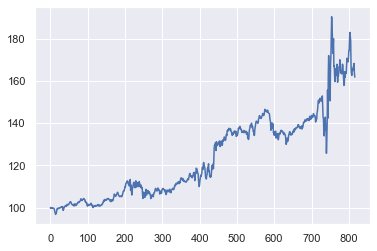

In [15]:
ann_return, history = stock_score(y_test_preds)
print('Annual return:', ann_return)

sns.lineplot(range(len(history)), history)

In [16]:
# rf.best_estimator_.save_model('../models/GradientBoosting/0001.model')

### MLPClassifier

In [17]:
parameters = {
    'solver': ['sgd'], 
    'max_iter': [1000],
    'alpha': 10.0 ** -np.arange(1, 10),
    'hidden_layer_sizes': np.arange(10, 15),
    'random_state': [0],
    'learning_rate_init': [0.15],
    'learning_rate': ['constant'],
    'shuffle': [False],
    'momentum': np.random.uniform(low=0.8, high=1, size=(50,))
}

rf = RandomizedSearchCV(MLPClassifier(), param_distributions=parameters,
                        cv=5, n_iter=20, scoring='recall', n_jobs=-1)

rf.fit(X_train, y_train)
y_test_preds = rf.predict(X_test)
y_train_preds = rf.predict(X_train)

In [18]:
print(accuracy_score(y_test, y_test_preds))
print(f1_score(y_test, y_test_preds))
print(recall_score(y_test, y_test_preds))
print(precision_score(y_test, y_test_preds))

0.5091799265605875
0.5030978934324658
0.4451754385964912
0.5783475783475783


[*********************100%***********************]  1 of 1 completed
Annual return: -8.561879791768035


<AxesSubplot:>

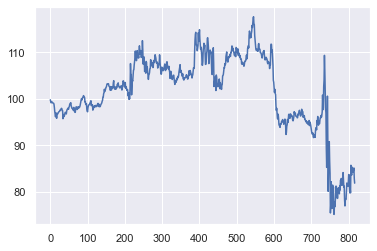

In [19]:
ann_return, history = stock_score(y_test_preds)
print('Annual return:', ann_return)

sns.lineplot(range(len(history)), history)

### Experimentation

In [20]:
clf = MLPClassifier(learning_rate_init=0.1,
                    solver='sgd',
                    momentum=0.9,
                    max_iter=1000,
                    shuffle=False, 
                    random_state=0
                )

clf.fit(X_train, y_train)
y_test_preds = clf.predict(X_test)

In [21]:
print('Accuracy:', accuracy_score(y_test, y_test_preds))
print('F1:', f1_score(y_test, y_test_preds))
print('Recall:', recall_score(y_test, y_test_preds))
print('Precision:', precision_score(y_test, y_test_preds))

Accuracy: 0.5556915544675642
F1: 0.6952141057934508
Recall: 0.9078947368421053
Precision: 0.563265306122449


[*********************100%***********************]  1 of 1 completed
Annual return: 91.30733081105915


<AxesSubplot:>

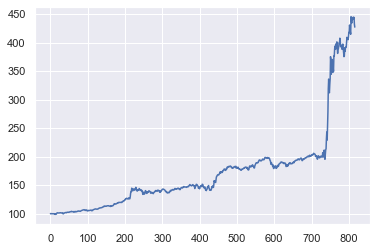

In [22]:
ann_return, history = stock_score(y_test_preds)
print('Annual return:', ann_return)

sns.lineplot(range(len(history)), history)

In [23]:
# joblib.dump(clf, '../models/MLPClassifier/0006.sav')